In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from SimLib import config_sim as conf
from SimLib import sipm_mapping as DAQ

%matplotlib nbagg

In [2]:
class TOF_compute(object):
    
    def __init__(self, path, file_name, SIPM, TDC_TE=1, time_bin=5):
        self.p_name = path
        self.f_name = file_name
        self.TDC_TE = TDC_TE
        self.time_bin = time_bin
        
        # SPE response computation
        self.n_sipms    = SIPM['n_sipms']
        self.first_sipm = SIPM['first_sipm']
        
        tau_sipm   = SIPM['tau_sipm']        
        time     = np.arange(0,100000,5)
        alfa = 1.0/tau_sipm[1]
        beta = 1.0/tau_sipm[0]
        t_p = np.log(beta/alfa)/(beta-alfa)
        K = (beta)*np.exp(alfa*t_p)/(beta-alfa)
        self.spe_resp = K*(np.exp(-time*alfa)-np.exp(-time*beta))
        
        os.chdir(path)
        self.tof_wave   = np.array(pd.read_hdf(file_name,key='MC/tof_waveforms'), 
                                   dtype='int')       
        
    def __call__(self,event):
        event_select    = np.argwhere(self.tof_wave[:,0]==event)
        event_tof       = self.tof_wave[event_select[:,0],1:]
        event_tof[:,0]  = event_tof[:,0]*-1-self.first_sipm
        # SiPM  |  Timebin  |  Charge
        pe_table = np.zeros((np.max(event_tof[:,1])+1,self.n_sipms))
    
        for i in range(event_tof.shape[0]):
            pe_table[event_tof[i,1],event_tof[i,0]] = event_tof[i,2]
        
        conv_table = np.zeros((np.max(event_tof[:,1])+1 + self.spe_resp.shape[0]-1,
                               self.n_sipms))

        for i in range(self.n_sipms):
            if np.max(pe_table[:,i])>0:
                conv_table[:,i] = np.convolve(pe_table[:,i],self.spe_resp)
    
        charge_acc = np.cumsum(conv_table,axis=0)
        
        timestamp_v = np.array([])
        for i in range(charge_acc.shape[1]):
            timestamp  = np.argwhere(charge_acc[:,i]>self.TDC_TE)
            if timestamp.size == 0:
                timestamp = 0
            else:
                timestamp  = np.min(timestamp)

            timestamp_v = np.hstack([timestamp_v,timestamp])
        
    
        return timestamp_v, charge_acc
    
    


# Extract Event Information

In [3]:
SIPM = {'n_sipms':3500, 'first_sipm':1000, 'tau_sipm':[250,15000]}
TDC = TOF_compute("/mnt/715c6d30-57c4-4aed-a982-551291d8f848/NEUTRINOS/","petit_ring_tof.h5",
                                 SIPM       = SIPM,
                                 TDC_TE     = 1,
                                 time_bin   = 5)

timestamp, accu_table = TDC(event = 126)

# Configuration Reading

In [4]:
path         = "/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/7mm_pitch/"
jsonfilename = "CUBE"
SIM_CONT=conf.SIM_DATA(filename=path+jsonfilename+".json",read=True)
data = SIM_CONT.data
L1_Slice, Matrix_I, Matrix_O, topo = DAQ.SiPM_Mapping(data,data['L1']['map_style'])


Number of SiPM : 3500 
Number of ASICS : 55 
Minimum Number of L1 : 6 
Available ASICS = 55
Connected ASICS = 55
Instanciated L1 = 6
L1 number 0 has 9 ASICs
L1 number 1 has 9 ASICs
L1 number 2 has 9 ASICs
L1 number 3 has 10 ASICs
L1 number 4 has 9 ASICs
L1 number 5 has 9 ASICs


# Image Composing

In [5]:
time = 10000
first_SiPM = 1000
phi_o = np.zeros(Matrix_O.shape)
# Data Matrix Composition
for i in range(Matrix_O.shape[0]):
    for j in range(Matrix_O.shape[1]):
        phi_o[i,j] = accu_table[time,int(Matrix_O[i,j])]

<IPython.core.display.Javascript object>


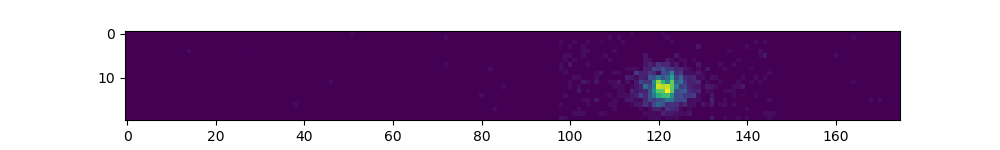

200.0


In [6]:
fig = plt.figure(figsize=(10,1.5))
plt.imshow(phi_o)
plt.show()
print np.min(timestamp[np.argwhere(timestamp>0)])

fig2 = plt.figure()
plt.plot(pe_table[:,645])
plt.show()

<IPython.core.display.Javascript object>


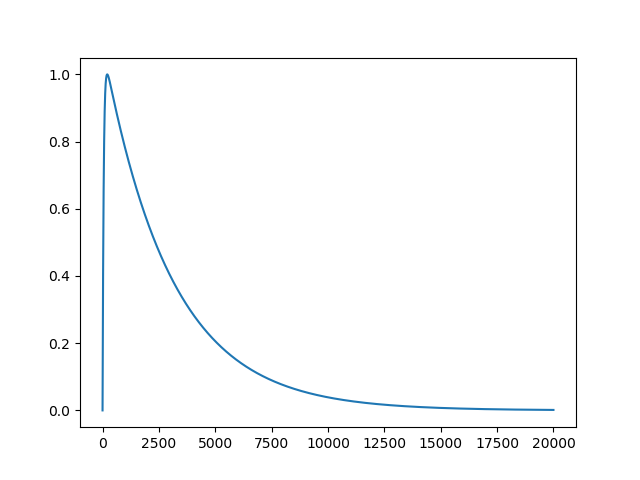

In [12]:
fig2 = plt.figure()
plt.plot(TDC.spe_resp)